# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)
This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/vram_usage.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc1_2_)    
    - [Job Efficiency Metrics](#toc1_2_1_)    
      - [Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc1_2_1_1_)    
    - [User Efficiency Metrics](#toc1_2_2_)    
      - [Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc1_2_2_1_)    
      - [Find Inefficient Users based on `vram_hours`](#toc1_2_2_2_)    
    - [PI Group Efficiency Metrics](#toc1_2_3_)    
      - [Find Inefficient PIs based on `vram_hours`](#toc1_2_3_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    
    - [Job Efficiency Metrics](#toc1_3_1_)    
      - [Problem with duplicate JobIDs](#toc1_3_1_1_)    
      - [Top users with most number of jobs that have no VRAM constraints](#toc1_3_1_2_)    
      - [Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc1_3_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [2]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [3]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: /Users/Ardavan/Documents/University of Massachusetts Amherst (UMass)/CICS/DS4CG/ds4cg-job-analytics


In [4]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import vram_usage

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 1
%aimport src.analysis.vram_usage, src.preprocess.preprocess, src.config.enum_constants

In [5]:
# Load the jobs DataFrame from DuckDB
preprocessed_jobs_df = vram_usage.load_preprocessed_jobs_dataframe_from_duckdb(
    db_path='../data/slurm_data.db',
    table_name='Jobs',
    )
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to ../data/slurm_data.db
Disconnected from ../data/slurm_data.db


,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs
20,28982142,-1,p3,False,non-interactive,pi_allan_umass_edu,nazaninjafar_umass_edu,[],gypsum-phd-rtx8000,TIMEOUT,...,[rtx_8000],0.000000e+00,0.0,1.046647e+09,0.158025,0 days 00:00:01,<NA>,48,249,867
21,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,COMPLETED,...,[a100],8.491159e+10,100.0,9.295657e+10,97.740585,0 days 00:04:43,320,640,356,2046
22,29004768,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AT95),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,OUT_OF_MEMORY,...,[l40s],9.625928e+08,100.0,3.691685e+10,16.136250,2 days 06:24:31,23,48,11125,11251
23,29004931,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AUH4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,OUT_OF_MEMORY,...,[l40s],4.865393e+08,100.0,3.864463e+10,16.197411,2 days 06:53:21,23,48,11125,11251
24,29004942,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4K5Y4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[l40s],9.500099e+08,100.0,2.878319e+10,16.564669,2 days 07:05:05,23,48,11125,11251
26,29004957,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9S9Q9),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a40],9.059697e+08,100.0,2.126001e+10,13.485684,2 days 06:52:20,23,48,11125,11251
28,29004977,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8GWC3),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],1.389363e+08,100.0,9.670738e+09,16.328876,2 days 06:33:21,23,23,11125,11251
29,29005003,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q0WQN4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],2.502164e+08,100.0,9.522024e+09,15.754887,2 days 06:09:00,23,23,11125,11251
30,29005010,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8GYL7),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[v100],6.878659e+08,100.0,2.109012e+10,16.048647,2 days 06:06:42,23,32,11125,11251
31,29005014,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9LRA9),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],2.513961e+08,100.0,1.088179e+10,16.628517,2 days 06:00:55,23,23,11125,11251


(934841, 30)


## <a id='toc1_2_'></a>[Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc0_)


In [6]:
efficiency_analysis = vram_usage.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)

In [7]:
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)
filtered_jobs

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs
20,28982142,-1,p3,False,non-interactive,pi_allan_umass_edu,nazaninjafar_umass_edu,[],gypsum-phd-rtx8000,TIMEOUT,...,[rtx_8000],0.0,0.0,1.046647e+09,0.158025,0 days 00:00:01,<NA>,48,249,867
281,29039483,-1,bash,False,shell,pi_chuangg_umass_edu,zeyuanyang_umass_edu,['a100'],normal,PREEMPTED,...,[a100],0.0,0.0,3.502080e+06,0.000110,0 days 18:06:57,<NA>,80,1184,27050
1383,29051995,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_jtaneja_umass_edu,nagyemangser_umass_edu,['x86_64'],normal,TIMEOUT,...,[1080_ti],0.0,0.0,1.579254e+11,16.614201,0 days 00:00:10,<NA>,11,125,2421
1452,28615235,12,entrycostest,True,non-interactive,pi_dmohapatra_umass_edu,dmohapatra_umass_edu,[],normal,PREEMPTED,...,[1080_ti],0.0,0.0,2.670657e+10,99.715240,0 days 00:02:11,<NA>,11,18330,18330
1454,29052220,-1,startjob2.sh,False,shell,pi_smaji_umass_edu,jmhamilton_umass_edu,['a100'],short,TIMEOUT,...,[a100],0.0,0.0,1.965409e+10,19.605003,0 days 00:00:09,<NA>,40,3276,16164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8369526,38286372,-1,forecasting_lorenz_config_non_probabilistic_la...,False,non-interactive,pi_mfiterau_umass_edu,edmondcunnin_umass_edu,"['a40', 'a100', 'rtx8000', 'a16', '2080ti', '1...",normal,COMPLETED,...,[2080_ti],0.0,0.0,4.743225e+09,42.370152,0 days 00:00:14,<NA>,11,17895,29377
8369529,38286383,-1,forecasting_fitzhugh_config_ar_nll_obs_wiener_...,False,non-interactive,pi_mfiterau_umass_edu,edmondcunnin_umass_edu,"['a40', 'a100', 'rtx8000', 'a16', '2080ti', '1...",normal,COMPLETED,...,[2080_ti],0.0,0.0,4.967211e+09,42.385811,0 days 00:00:13,<NA>,11,17895,29377
8369530,38286384,-1,forecasting_fitzhugh_config_diffusion_obs_wien...,False,non-interactive,pi_mfiterau_umass_edu,edmondcunnin_umass_edu,"['a40', 'a100', 'rtx8000', 'a16', '2080ti', '1...",normal,COMPLETED,...,[2080_ti],0.0,0.0,6.534599e+09,35.427689,0 days 00:00:13,<NA>,11,17895,29377
8369531,38286390,-1,forecasting_lotka_config_ar_nll_obs_brownian_t...,False,non-interactive,pi_mfiterau_umass_edu,edmondcunnin_umass_edu,"['a40', 'a100', 'rtx8000', 'a16', '2080ti', '1...",normal,COMPLETED,...,[2080_ti],0.0,0.0,1.744044e+09,24.442934,0 days 00:00:13,<NA>,11,17895,29377


Generate all metrics:

In [12]:
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict['jobs_with_efficiency_metrics']
users_with_metrics = metrics_dict['users_with_efficiency_metrics']
pi_accounts_with_metrics = metrics_dict['pi_accounts_with_efficiency_metrics']

### <a id='toc1_2_1_'></a>[Job Efficiency Metrics](#toc0_)

In [13]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
20,28982142,-1,p3,False,non-interactive,pi_allan_umass_edu,nazaninjafar_umass_edu,[],gypsum-phd-rtx8000,TIMEOUT,SUCCESS,2025-02-15 18:08:28,2025-02-15 18:08:29,4 days 00:00:01,0 days 01:36:00,gypsum-rtx8000,[gypsum-gpu188],2,1,[rtx_8000],0.0,0.0,0.158025,0 days 00:00:01,<NA>,48,249,867,96.000278,4608.013333,0.0,0.0,<NA>,-inf,<NA>,0.974766,28.087891,0.034704
281,29039483,-1,bash,False,shell,pi_chuangg_umass_edu,zeyuanyang_umass_edu,['a100'],normal,PREEMPTED,SUCCESS,2025-02-18 21:26:15,2025-02-19 15:33:12,0 days 02:18:01,0 days 00:08:00,gpu-preempt,[gpu021],16,1,[a100],0.0,0.0,0.000110,0 days 18:06:57,<NA>,80,1184,27050,2.300278,184.022222,0.0,0.0,<NA>,-inf,<NA>,0.003262,80.000000,0.000041
1383,29051995,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_jtaneja_umass_edu,nagyemangser_umass_edu,['x86_64'],normal,TIMEOUT,SUCCESS,2025-02-19 14:22:49,2025-02-19 14:22:59,0 days 08:00:09,0 days 00:08:00,gpu,[gypsum-gpu116],12,1,[1080_ti],0.0,0.0,16.614201,0 days 00:00:10,<NA>,11,125,2421,8.0025,88.0275,0.0,0.0,<NA>,-inf,<NA>,147.079483,300.000000,0.490265
1452,28615235,12,entrycostest,True,non-interactive,pi_dmohapatra_umass_edu,dmohapatra_umass_edu,[],normal,PREEMPTED,SUCCESS,2025-02-19 14:52:53,2025-02-19 14:55:04,0 days 04:57:45,0 days 00:48:00,gpu-preempt,[gypsum-gpu150],1,1,[1080_ti],0.0,0.0,99.715240,0 days 00:02:11,<NA>,11,18330,18330,4.9625,54.5875,0.0,0.0,<NA>,-inf,<NA>,24.872429,250.000000,0.099490
1454,29052220,-1,startjob2.sh,False,shell,pi_smaji_umass_edu,jmhamilton_umass_edu,['a100'],short,TIMEOUT,SUCCESS,2025-02-19 14:56:09,2025-02-19 14:56:18,0 days 04:00:05,0 days 00:04:00,gpu-preempt,[ece-gpu001],8,1,[a100],0.0,0.0,19.605003,0 days 00:00:09,<NA>,40,3276,16164,4.001389,160.055556,0.0,0.0,<NA>,-inf,<NA>,18.304298,62.500000,0.292869
1474,29052309,-1,interactive,False,shell,pi_eokte_umass_edu,agnesli_umass_edu,[],short,TIMEOUT,SUCCESS,2025-02-19 15:15:06,2025-02-19 15:15:43,0 days 03:00:25,0 days 00:03:00,gpu-preempt,[gypsum-gpu151],1,1,[1080_ti],0.0,0.0,2.117634,0 days 00:00:37,<NA>,11,271,402,3.006944,33.076389,0.0,0.0,<NA>,-inf,<NA>,4.243404,250.000000,0.016974
1478,29052319,-1,dev-gpu,False,non-interactive,pi_gvanhorn_umass_edu,lclawrence_umass_edu,[],normal,PREEMPTED,SUCCESS,2025-02-19 15:16:02,2025-02-19 15:16:21,0 days 04:37:04,0 days 00:08:00,gpu-preempt,[gypsum-gpu127],16,1,[1080_ti],0.0,0.0,0.383273,0 days 00:00:19,<NA>,11,3639,7695,4.617778,50.795556,0.0,0.0,<NA>,-inf,<NA>,0.881802,64.000000,0.013778
1518,28615241,24,entrycostest,True,non-interactive,pi_dmohapatra_umass_edu,dmohapatra_umass_edu,[],normal,PREEMPTED,SUCCESS,2025-02-19 15:34:44,2025-02-19 15:36:50,0 days 04:15:59,0 days 00:48:00,gpu-preempt,[gypsum-gpu140],1,1,[1080_ti],0.0,0.0,98.797119,0 days 00:02:06,<NA>,11,18330,18330,4.266389,46.930278,0.0,0.0,<NA>,-inf,<NA>,24.882389,250.000000,0.099530
1525,28615242,25,entrycostest,True,non-interactive,pi_dmohapatra_umass_edu,dmohapatra_umass_edu,[],normal,PREEMPTED,SUCCESS,2025-02-19 15:39:33,2025-02-19 15:41:49,0 days 04:11:00,0 days 00:48:00,gpu-preempt,[gypsum-gpu117],1,1,[1080_ti],0.0,0.0,99.681152,0 days 00:02:16,<NA>,11,18330,18330,4.183333,46.016667,0.0,0.0,<NA>,-inf,<NA>,24.859211,250.000000,0.099437
1539,29052746,-1,interactive,False,shell,pi_chuangg_umass_edu,sunlichen_umass_edu,[],normal,COMPLETED,SUCCESS,2025-02-19 15:54:06,2025-02-19 15:54:30,0 days 01:18:53,0 days 00:08:00,gpu-preempt,[gypsum-gpu085],1,1,[titan_x],0.0,0.0,5.809387,0 days 00:00:24,<NA>,12,17293,27050,1.314722,15.776667,0.0,0.0,<NA>,-inf,<NA>,0.998360,1.000

Jobs found: 67086


#### <a id='toc1_2_1_1_'></a>[Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc0_)


Top inefficient Jobs by VRAM-hours:


,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
3243937,25094304,-1,trainunity.sh,False,non-interactive,pi_ashgiri_uri_edu,achyut_subedi_uri_edu,[],normal,TIMEOUT,...,1344.018889,430086.044444,0.0,0.0,<NA>,-inf,<NA>,6.600376,500.000000,0.013201
2902663,25663846,-1,1e4-bw6,False,non-interactive,pi_candela_umass_edu,ejdwight_umass_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",long,TIMEOUT,...,2880.043333,414726.24,0.0,0.0,<NA>,-inf,<NA>,2.453487,43.945312,0.055830
2902664,25663945,-1,1e4coulhDeltaMX,False,non-interactive,pi_candela_umass_edu,ejdwight_umass_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",long,TIMEOUT,...,2880.03,414724.32,0.0,0.0,<NA>,-inf,<NA>,13.604195,43.945312,0.309571
3984756,24689859,-1,BATCH_SCRIPT,False,non-interactive,pi_erno_sajo_uml_edu,diana_thompson_student_uml_edu,[],normal,COMPLETED,...,342.016667,410420.0,0.0,0.0,<NA>,-inf,<NA>,6.856304,16.000000,0.428519
8232748,38149589,-1,glide-dock_chain_B.sh,False,non-interactive,pi_xiaohuizhang_umass_edu,hhargrove_umass_edu,[],normal,TIMEOUT,...,384.071111,294966.613333,0.0,0.0,<NA>,-inf,<NA>,2.984634,40.000000,0.074616
2964013,25663852,-1,1e4-bw5,False,non-interactive,pi_candela_umass_edu,ejdwight_umass_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",long,COMPLETED,...,2014.62,290105.28,0.0,0.0,<NA>,-inf,<NA>,2.430229,43.945312,0.055301
4505014,29576693,-1,sys/dashboard/sys/bc_desktop,False,bc_desktop,pi_jianhanc_umass_edu,sbarethiya_umass_edu,['x86_64'],normal,TIMEOUT,...,2688.04,236547.52,0.0,0.0,<NA>,-inf,<NA>,127.980667,128.000000,0.999849
2661448,26116254,-1,topas.slurm,False,non-interactive,pi_mantosh_uri_edu,brett_ruben_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,TIMEOUT,...,576.113333,165920.64,0.0,0.0,<NA>,-inf,<NA>,11.971142,72.000000,0.166266
2661447,26116251,-1,topas.slurm,False,non-interactive,pi_mantosh_uri_edu,brett_ruben_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,TIMEOUT,...,576.113333,165920.64,0.0,0.0,<NA>,-inf,<NA>,11.971134,72.000000,0.166266
2052042,26653641,-1,eah,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],long,NODE_FAIL,...,1853.235556,163084.728889,0.0,0.0,<NA>,-inf,<NA>,0.000244,15.625000,0.000016


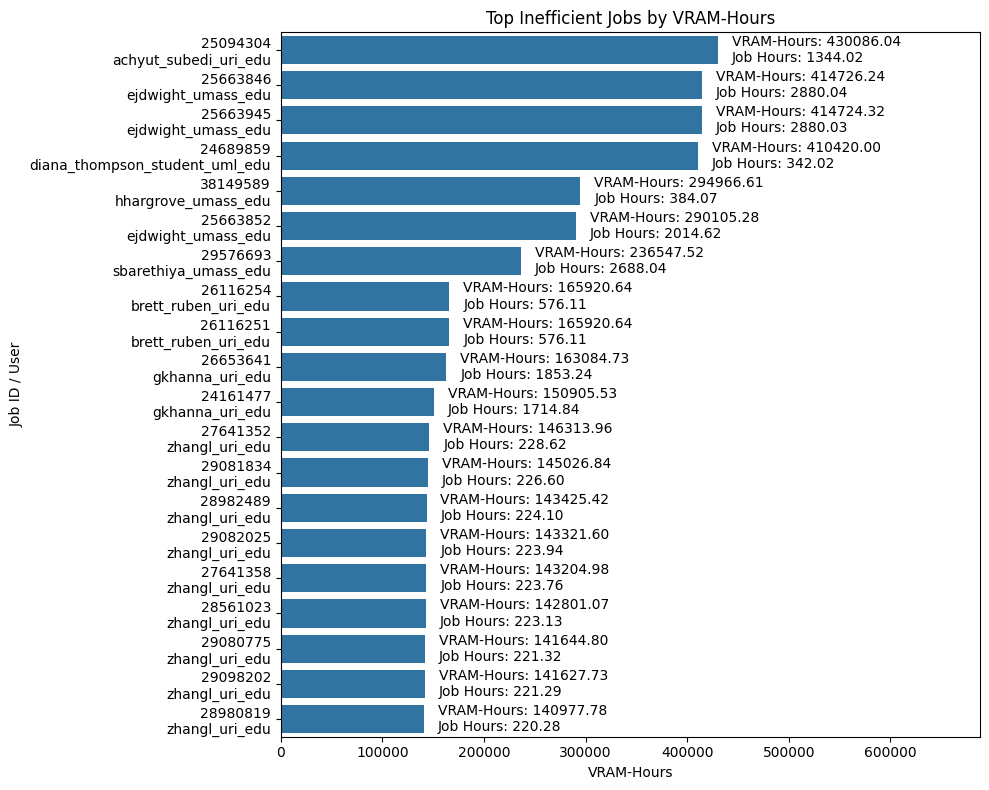

In [15]:
inefficient_jobs_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=vram_usage.MetricsDataFrameNameEnum.JOBS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
    filter_criteria={
        "vram_hours": {"min": 80 * 24, "inclusive": True},  # VRAM-hours threshold for identifying inefficient jobs
    }
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient Jobs by VRAM-hours:")
display(inefficient_jobs_vram_hours.head(10))

top_jobs = inefficient_jobs_vram_hours.head(20)

# Plot top inefficient jobs by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(10, 8))

# Create y-tick labels with JobID and User
yticklabels = [f"{jid}\n{user}" for jid, user in zip(top_jobs["JobID"], top_jobs["User"], strict=True)]

barplot = sns.barplot(
    y=yticklabels,
    x=top_jobs["vram_hours"],
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("Job ID / User")
plt.title("Top Inefficient Jobs by VRAM-Hours")

ax = barplot
xmax = top_jobs["vram_hours"].max()
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)

for i, (vram_hours, job_hours) in enumerate(
    zip(top_jobs["vram_hours"], top_jobs["job_hours"], strict=True)
):
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\nJob Hours: {job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()


### <a id='toc1_2_2_'></a>[User Efficiency Metrics](#toc0_)

In [16]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
0,aabedeen_umass_edu,1,8.005,pi_pkatz_umass_edu,<NA>,<NA>,0.0,<NA>,12.000000,96.060000
1,aaditya_umass_edu,122,939.793889,pi_dganesan_umass_edu,<NA>,<NA>,0.0,<NA>,44.832151,42132.981111
2,aagrawal_umass_edu,2,2.2875,pi_jdomke_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,183.000000
3,aamballa_umass_edu,1,4.006944,pi_hongyu_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,320.555556
4,aanjali_umass_edu,17,27.431667,pi_jtaneja_umass_edu,<NA>,<NA>,0.0,<NA>,24.619458,675.352778
...,...,...,...,...,...,...,...,...,...,...
744,zonghaiyao_umass_edu,1,18.952222,pi_hongyu_umass_edu,<NA>,<NA>,0.0,<NA>,11.000000,208.474444
745,zplumridge_smith_edu,1,2.336111,pi_hrando_smith_edu,<NA>,<NA>,0.0,<NA>,92.000000,107.461111
746,zshah_umass_edu,4,24.011667,pi_jtaneja_umass_edu,<NA>,<NA>,0.0,<NA>,11.499977,276.133611
747,zubin_bhuyan_student_uml_edu,6,6.524444,pi_yuanchang_xie_uml_edu,<NA>,<NA>,0.0,<NA>,48.000000,313.173333


#### <a id='toc1_2_2_1_'></a>[Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc0_)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
1,aaditya_umass_edu,122,939.793889,pi_dganesan_umass_edu,<NA>,<NA>,0.0,<NA>,44.832151,42132.981111
499,rahulsaxena_umass_edu,10,39.660556,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,<NA>,16.767464,665.006944
498,radsul_umass_edu,18,75.119444,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,<NA>,29.362959,1588.494722
496,qizhengyang_umass_edu,144,1205.346667,pi_huiguan_umass_edu,<NA>,<NA>,0.0,<NA>,33.622654,40526.953889
495,qinhongzhou_umass_edu,229,653.022222,pi_chuangg_umass_edu,<NA>,<NA>,0.0,<NA>,74.198694,33321.396111
493,pvinod_umassd_edu,25,181.4025,pi_sfield_umassd_edu,<NA>,<NA>,0.0,<NA>,74.292237,13476.797500
492,pvashisht_umass_edu,63,421.796667,pi_hongyu_umass_edu,<NA>,<NA>,0.0,<NA>,22.301121,9406.538333
488,pthejaswi_umass_edu,30,33.778889,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,<NA>,15.320771,517.518611
487,ptarale_umass_edu,131,1149.876944,pi_hava_umass_edu,<NA>,<NA>,0.0,<NA>,12.229223,14017.966667
485,psshetty_umass_edu,46,158.968333,pi_hzamani_umass_edu,<NA>,<NA>,0.0,<NA>,13.447301,2137.695000


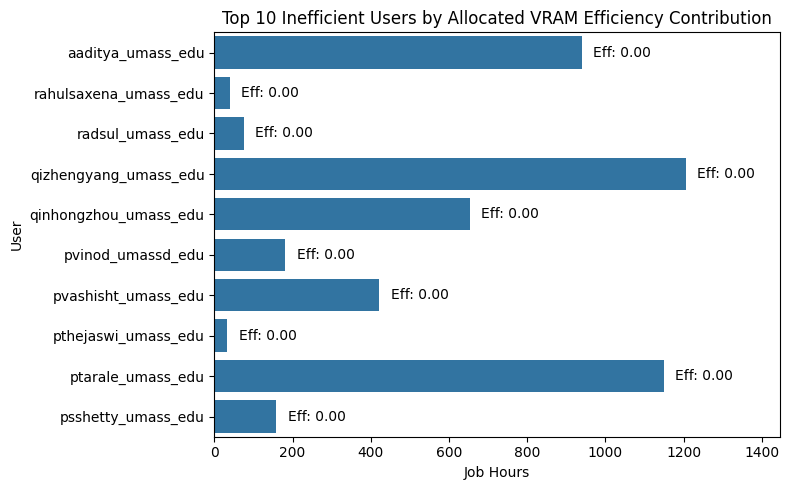

In [17]:
inefficient_users = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=vram_usage.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    }
)

# Display top inefficient users by job count
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users.head(10))


# Plot top inefficient users by GPU hours, with efficiency as labels
top_users = inefficient_users.head(10)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["user_job_hours"],
    orient="h"
)
plt.xlabel("Job Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by Allocated VRAM Efficiency Contribution")

# Annotate bars with expected_value_alloc_vram_efficiency, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["user_job_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.20 if xmax > 0 else 1
ax.set_xlim(0, xlim)

# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (job_hours, efficiency) in enumerate(
    zip(
        top_users["user_job_hours"],
        top_users["expected_value_alloc_vram_efficiency"],
        strict=True,
    )
):
    # Place annotation at min(job_hours + 2% of xlim, 98% of xlim)
    xpos = min(job_hours + xlim * 0.02, xlim * 0.98)
    # If bar is very close to right spine, nudge annotation left to avoid overlap
    if xpos > xlim * 0.96:
        xpos = xlim * 0.96
    ax.text(
        xpos,
        i,
        f"Eff: {efficiency:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()

#### <a id='toc1_2_2_2_'></a>[Find Inefficient Users based on `vram_hours`](#toc0_)


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
736,zhangl_uri_edu,265,36050.061111,pi_zhangl_uri_edu,<NA>,<NA>,0.0,<NA>,1181.348605,6.862939e+06
290,juhyeonlee_umass_edu,701,22513.4975,pi_sunghoonlee_umass_edu,<NA>,<NA>,0.0,<NA>,589.923688,1.890495e+06
183,ejdwight_umass_edu,87,12602.062222,pi_candela_umass_edu,<NA>,<NA>,0.0,<NA>,1466.566443,1.750671e+06
229,ibrahim_isah_student_uml_edu,100,2529.670833,pi_stephen_lam_uml_edu,<NA>,<NA>,0.0,<NA>,32569.307458,1.474869e+06
537,sbarethiya_umass_edu,1674,17241.420556,pi_jianhanc_umass_edu,<NA>,<NA>,0.0,<NA>,462.593299,1.056812e+06
203,gkhanna_uri_edu,621,28452.268889,pi_gkhanna_uri_edu,<NA>,<NA>,0.0,<NA>,197.891669,9.837898e+05
165,dmohapatra_umass_edu,7570,30488.012778,pi_dmohapatra_umass_edu,<NA>,<NA>,0.0,<NA>,31.499874,9.520628e+05
542,sdandekar_umass_edu,171,3679.84,pi_sniekum_umass_edu,<NA>,<NA>,0.0,<NA>,809.231792,8.310681e+05
230,ibrahim_isah_uml_edu,85,4492.715556,pi_stephen_lam_uml_edu,<NA>,<NA>,0.0,<NA>,1375.220796,8.012638e+05
414,mthalanki_umass_edu,315,12233.063056,pi_mfiterau_umass_edu,<NA>,<NA>,0.0,<NA>,304.711533,7.736173e+05


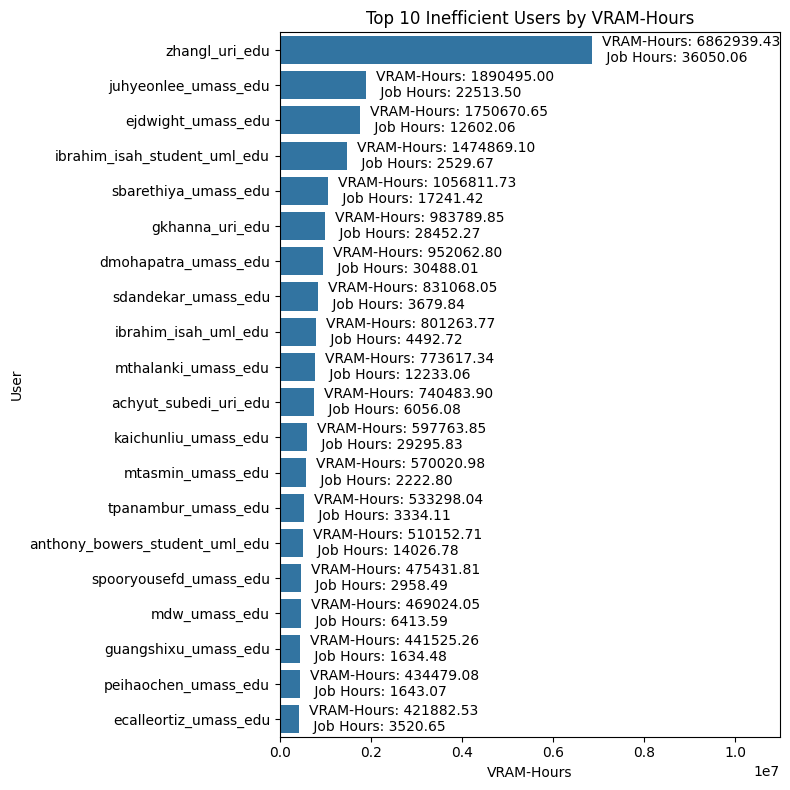

In [18]:
inefficient_users_vram_hours = efficiency_analysis.find_inefficient_users_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(20))

top_users = inefficient_users_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["vram_hours"],
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, user_job_hours) in enumerate(
    zip(
        top_users["vram_hours"],
        top_users["user_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {user_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

### <a id='toc1_2_3_'></a>[PI Group Efficiency Metrics](#toc0_)

In [19]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count
0,pi_allan_umass_edu,104,1047.070833,4,57928.363056,<NA>,<NA>,0.0,<NA>,136.932412
1,pi_jdomke_umass_edu,206,1401.218056,4,53627.054167,<NA>,<NA>,0.0,<NA>,90.130226
2,pi_jaewoong_jung_uri_edu,2,1.243333,1,14.920000,<NA>,<NA>,0.0,<NA>,12.000000
3,pi_gkul_umassd_edu,18,55.070556,2,1247.525556,<NA>,<NA>,0.0,<NA>,42.682802
4,pi_jensen_umass_edu,162,1061.425556,4,45304.099167,<NA>,<NA>,0.0,<NA>,69.824385
...,...,...,...,...,...,...,...,...,...,...
241,pi_mfiterau_umass_edu,1973,17238.878611,19,929236.056111,<NA>,<NA>,0.0,<NA>,286.480571
242,pi_hongyu_umass_edu,701,3821.351667,31,250241.377778,<NA>,<NA>,0.0,<NA>,1245.909925
243,pi_dtowsley_umass_edu,68,2958.487778,1,475431.811111,<NA>,<NA>,0.0,<NA>,1887.647559
244,pi_jeff_dusenberry_umb_edu,1,1.125278,1,106.901389,<NA>,<NA>,0.0,<NA>,95.000000


#### <a id='toc1_2_3_1_'></a>[Find Inefficient PIs based on `vram_hours`](#toc0_)


Top inefficient PI Groups by VRAM-hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count
61,pi_zhangl_uri_edu,272,37023.16,3,7.170725e+06,<NA>,<NA>,0.0,<NA>,1185.486762
179,pi_sunghoonlee_umass_edu,4583,54265.600278,8,2.545114e+06,<NA>,<NA>,0.0,<NA>,445.088593
5,pi_stephen_lam_uml_edu,374,9792.338333,6,2.363990e+06,<NA>,<NA>,0.0,<NA>,20788.522698
163,pi_candela_umass_edu,89,12602.948611,2,1.750684e+06,<NA>,<NA>,0.0,<NA>,1466.555159
65,pi_jianhanc_umass_edu,2322,29511.812222,5,1.443115e+06,<NA>,<NA>,0.0,<NA>,383.011622
233,pi_chuangg_umass_edu,1987,11826.380556,20,1.198147e+06,<NA>,<NA>,0.0,<NA>,573.072358
76,pi_hzamani_umass_edu,782,9693.396944,16,1.045132e+06,<NA>,<NA>,0.0,<NA>,711.619745
159,pi_sniekum_umass_edu,325,4619.610278,5,1.002236e+06,<NA>,<NA>,0.0,<NA>,828.049135
72,pi_gkhanna_uri_edu,658,28820.24,5,9.916190e+05,<NA>,<NA>,0.0,<NA>,196.818932
36,pi_dmohapatra_umass_edu,7570,30488.012778,1,9.520628e+05,<NA>,<NA>,0.0,<NA>,31.499874


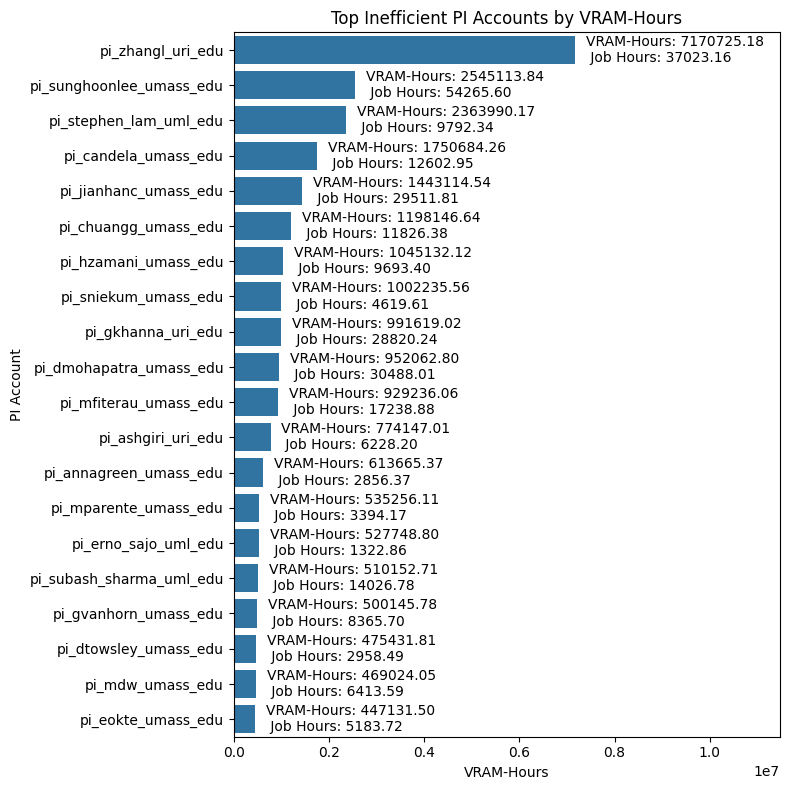

In [20]:
inefficient_pis_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=vram_usage.MetricsDataFrameNameEnum.PI_GROUPS,
    sorting_key="pi_acc_vram_hours",
    ascending=False,
    filter_criteria={
        "pi_acc_vram_hours": {"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a PI account
    }
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-hours:")
display(inefficient_pis_vram_hours.head(20))

top_pi_accounts = inefficient_pis_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_pi_accounts["pi_account"],
    x=top_pi_accounts["pi_acc_vram_hours"],
    order=top_pi_accounts["pi_account"].tolist(),  # Only show present values
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("PI Account")
plt.title("Top Inefficient PI Accounts by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_pi_accounts["pi_acc_vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, pi_acc_job_hours) in enumerate(
    zip(
        top_pi_accounts["pi_acc_vram_hours"],
        top_pi_accounts["pi_acc_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {pi_acc_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Example: Analyze all jobs with no VRAM constraints](#toc0_)

In [21]:
# Filter jobs where no VRAM constraint was set but a GPU was allocated
no_vram_constraint_efficiency_analysis = vram_usage.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)
all_no_vram_constraint_jobs = no_vram_constraint_efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter={"min": 0, "inclusive": False},  # No VRAM constraints
    gpu_count_filter={"min": 1, "inclusive": True},  # At least one GPU allocated
    gpu_mem_usage_filter={"min": 0, "inclusive": False}  # Used more than 0 GiB of VRAM
)

display(all_no_vram_constraint_jobs.head(10))
print(all_no_vram_constraint_jobs.shape)

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs
21,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,COMPLETED,...,[a100],8.491159e+10,100.0,9.295657e+10,97.740585,0 days 00:04:43,320,640,356,2046
22,29004768,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AT95),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,OUT_OF_MEMORY,...,[l40s],9.625928e+08,100.0,3.691685e+10,16.136250,2 days 06:24:31,23,48,11125,11251
23,29004931,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AUH4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,OUT_OF_MEMORY,...,[l40s],4.865393e+08,100.0,3.864463e+10,16.197411,2 days 06:53:21,23,48,11125,11251
24,29004942,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4K5Y4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[l40s],9.500099e+08,100.0,2.878319e+10,16.564669,2 days 07:05:05,23,48,11125,11251
26,29004957,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9S9Q9),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[a40],9.059697e+08,100.0,2.126001e+10,13.485684,2 days 06:52:20,23,48,11125,11251
28,29004977,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8GWC3),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],1.389363e+08,100.0,9.670738e+09,16.328876,2 days 06:33:21,23,23,11125,11251
29,29005003,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q0WQN4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],2.502164e+08,100.0,9.522024e+09,15.754887,2 days 06:09:00,23,23,11125,11251
30,29005010,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8GYL7),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[v100],6.878659e+08,100.0,2.109012e+10,16.048647,2 days 06:06:42,23,32,11125,11251
31,29005014,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9LRA9),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],2.513961e+08,100.0,1.088179e+10,16.628517,2 days 06:00:55,23,23,11125,11251
32,29005019,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9SYN5),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,...,[m40],2.502164e+08,100.0,9.867768e+09,16.449804,2 days 05:57:00,23,23,11125,11251


(111443, 30)


### <a id='toc1_3_1_'></a>[Job Efficiency Metrics](#toc0_)

In [22]:
no_vram_constraint_jobs_with_metrics = no_vram_constraint_efficiency_analysis.calculate_job_efficiency_metrics(
    all_no_vram_constraint_jobs
    )

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(no_vram_constraint_jobs_with_metrics)}")

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
21,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,COMPLETED,SUCCESS,2025-02-16 07:44:48,2025-02-16 07:49:31,3 days 14:28:36,0 days 02:13:00,superpod-a100,[gpu014],8,8,[a100],8.491159e+10,100.0,97.740585,0 days 00:04:43,320,640,356,2046,691.813333,442760.533333,79.080078,0.123563,0.247125,-925815.458705,-618917.243362,86.572556,200.0,0.432863
22,29004768,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AT95),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,OUT_OF_MEMORY,SIGNALED,2025-02-17 06:10:19,2025-02-19 12:34:50,0 days 07:23:22,0 days 00:08:00,gpu,[gpu029],6,1,[l40s],9.625928e+08,100.0,16.136250,2 days 06:24:31,23,48,11125,11251,7.389444,354.693333,0.896484,0.018677,0.038978,-1411.848097,-1150.897802,34.381493,36.0,0.955041
23,29004931,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AUH4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,OUT_OF_MEMORY,SIGNALED,2025-02-17 07:13:19,2025-02-19 14:06:40,0 days 04:51:05,0 days 00:08:00,gpu,[gpu031],6,1,[l40s],4.865393e+08,100.0,16.197411,2 days 06:53:21,23,48,11125,11251,4.851389,232.866667,0.453125,0.009440,0.019701,-1085.80796,-914.486371,35.990612,36.0,0.999739
24,29004942,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4K5Y4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 07:22:49,2025-02-19 14:27:54,0 days 02:08:13,0 days 00:08:00,gpu,[gpu032],6,1,[l40s],9.500099e+08,100.0,16.564669,2 days 07:05:05,23,48,11125,11251,2.136944,102.573333,0.884766,0.018433,0.038468,-409.640301,-334.176403,26.806431,36.0,0.744623
26,29004957,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9S9Q9),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 07:39:19,2025-02-19 14:31:39,0 days 02:01:14,0 days 00:08:00,gpu,[gpu009],6,1,[a40],9.059697e+08,100.0,13.485684,2 days 06:52:20,23,48,11125,11251,2.020556,96.986667,0.843750,0.017578,0.036685,-391.932823,-320.579074,19.799923,36.0,0.549998
28,29004977,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8GWC3),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 08:00:49,2025-02-19 14:34:10,0 days 04:59:53,0 days 00:08:00,gpu,[gypsum-gpu007],6,1,[m40],1.389363e+08,100.0,16.328876,2 days 06:33:21,23,23,11125,11251,4.998056,114.955278,0.129395,0.005626,0.005626,-595.51241,-595.51241,9.006577,36.0,0.250183
29,29005003,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q0WQN4),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 08:28:49,2025-02-19 14:37:49,0 days 05:30:27,0 days 00:08:00,gpu,[gypsum-gpu016],6,1,[m40],2.502164e+08,100.0,15.754887,2 days 06:09:00,23,23,11125,11251,5.5075,126.6725,0.233032,0.010132,0.010132,-581.689334,-581.689334,8.868076,36.0,0.246335
30,29005010,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q8GYL7),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 08:32:19,2025-02-19 14:39:01,0 days 02:58:42,0 days 00:08:00,gpu,[gpu011],6,1,[v100],6.878659e+08,100.0,16.048647,2 days 06:06:42,23,32,11125,11251,2.978333,95.306667,0.640625,0.020020,0.027853,-372.748845,-341.274611,19.641705,36.0,0.545603
31,29005014,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-Q9LRA9),False,non-interactive,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,COMPLETED,SUCCESS,2025-02-17 08:39

Jobs found: 111443


#### <a id='toc1_3_1_1_'></a>[Problem with duplicate JobIDs](#toc0_)

In [23]:
# select jobs with specific job id
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics[no_vram_constraint_jobs_with_metrics["JobID"] == 24374463])
pd.reset_option('display.max_columns')

,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
3945211,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-09-03 15:33:56,2024-09-04 02:12:01,0 days 02:08:20,0 days 02:48:00,gpu-preempt,"[gpu018, gpu019]",224,16,[a100],6.174015e+09,99.0,1.398886,0 days 10:38:05,640,1280,23,36,34.222222,43804.444444,5.75,0.004492,0.008984,-236781.223061,-206418.295898,57.617062,512.0,0.112533
3952302,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-29 20:02:59,2024-08-31 13:08:52,3 days 02:24:57,0 days 02:48:00,gpu-preempt,"[gpu014, gpu018]",224,16,[a100],6.174015e+09,100.0,1.425578,1 days 17:05:53,640,1280,23,36,1190.653333,1524036.266667,5.75,0.004492,0.008984,-8238049.261609,-7181667.820298,57.735668,512.0,0.112765
3987514,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-28 00:04:02,2024-08-28 12:01:14,1 days 08:01:37,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,[a100],6.174015e+09,100.0,1.419882,0 days 11:57:12,640,1280,23,36,512.431111,655911.822222,5.75,0.004492,0.008984,-3545475.931854,-3090832.501584,57.736538,512.0,0.112767
4002366,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-23 20:50:50,2024-08-24 05:52:24,3 days 18:11:35,0 days 02:48:00,gpu-preempt,"[gpu017, gpu020]",224,16,[a100],6.174015e+09,100.0,1.419324,0 days 09:01:34,640,1280,23,36,1443.088889,1847153.777778,5.75,0.004492,0.008984,-9984633.665171,-8704284.232043,57.648254,512.0,0.112594
4056623,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-21 15:08:27,2024-08-22 12:51:25,1 days 07:59:17,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,[a100],6.174015e+09,100.0,1.420042,0 days 21:42:58,640,1280,23,36,511.808889,655115.377778,5.75,0.004492,0.008984,-3541170.818707,-3087079.441659,57.734287,512.0,0.112762
4111462,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-20 16:15:30,2024-08-21 10:14:09,0 days 04:54:10,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,[a100],6.174015e+09,99.0,1.427450,0 days 17:58:39,640,1280,23,36,78.444444,100408.888889,5.75,0.004492,0.008984,-542751.764549,-473153.626313,57.712429,512.0,0.112720


#### <a id='toc1_3_1_2_'></a>[Top users with most number of jobs that have no VRAM constraints](#toc0_)

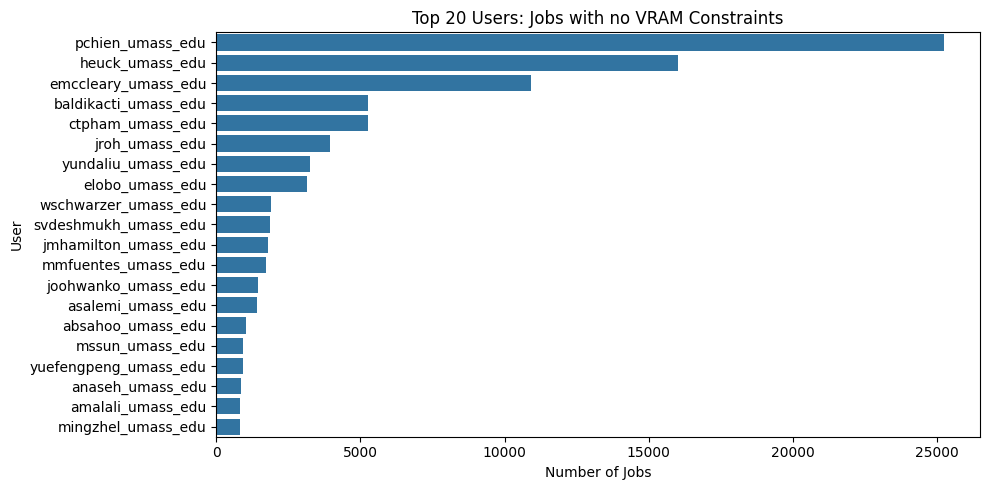

In [24]:
# Plot top users by number of jobs with no VRAM constraints
if not all_no_vram_constraint_jobs.empty:
    plt.figure(figsize=(10, 5))
    user_counts = all_no_vram_constraint_jobs["User"].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient="h")
    plt.xlabel("Number of Jobs")
    plt.ylabel("User")
    plt.title("Top 20 Users: Jobs with no VRAM Constraints")
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found without VRAM constraints.")

#### <a id='toc1_3_1_3_'></a>[Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc0_)


Top inefficient Jobs by allocated VRAM efficiency score:


,JobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
4002366,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,...,1443.088889,1847153.777778,5.750000,0.004492,0.008984,-9984633.665171,-8704284.232043,57.648254,512.0,0.112594
3952302,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,...,1190.653333,1524036.266667,5.750000,0.004492,0.008984,-8238049.261609,-7181667.820298,57.735668,512.0,0.112765
4316478,24009623,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,COMPLETED,...,590.542222,755894.044444,5.728516,0.004475,0.008951,-4088751.007772,-3564805.182063,45.587269,512.0,0.089038
3987514,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,...,512.431111,655911.822222,5.750000,0.004492,0.008984,-3545475.931854,-3090832.501584,57.736538,512.0,0.112767
4056623,24374463,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,...,511.808889,655115.377778,5.750000,0.004492,0.008984,-3541170.818707,-3087079.441659,57.734287,512.0,0.112762
4098467,24374462,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,COMPLETED,...,1082.04,692505.6,8.451172,0.013205,0.02641,-2996584.651972,-2516576.34781,57.801441,512.0,0.112893
4380856,24083335,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,COMPLETED,...,912.602222,584065.422222,6.875000,0.010742,0.021484,-2647905.291807,-2243061.991131,44.737995,512.0,0.087379
4424221,24009623,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,PREEMPTED,...,296.666667,379733.333333,5.728516,0.004475,0.008951,-2054037.944554,-1790826.855189,45.523563,512.0,0.088913
377223,28409832,-1,qwen_llamafactory,False,non-interactive,pi_miyyer_umass_edu,ctpham_umass_edu,"['a100-80g', 'gpu:a100']",normal,COMPLETED,...,1186.037778,759064.177778,69.851562,0.109143,0.218286,-1681399.812568,-1155256.617878,599.966187,600.0,0.999944
21,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,COMPLETED,...,691.813333,442760.533333,79.080078,0.123563,0.247125,-925815.458705,-618917.243362,86.572556,200.0,0.432863


Minimum Allocated VRAM Efficiency Score: -9984633.665170714


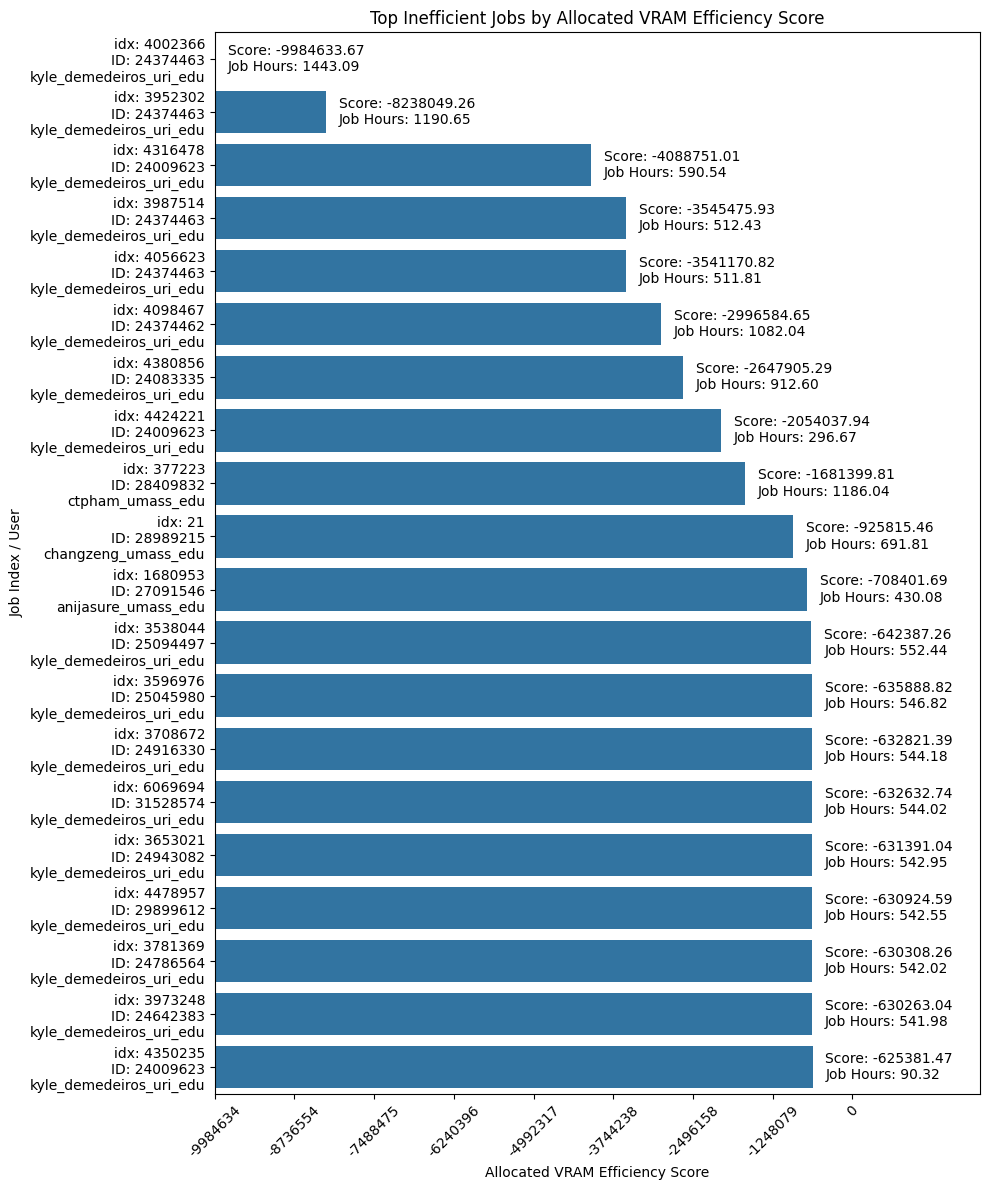

In [25]:
low_alloc_vram_score_jobs = no_vram_constraint_efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=vram_usage.MetricsDataFrameNameEnum.JOBS,
    sorting_key="alloc_vram_efficiency_score",
    ascending=True,  # Sort by alloc_vram_efficiency_score in ascending order
    filter_criteria={
        "alloc_vram_efficiency_score": {"max": -10, "inclusive": True},  # score threshold
    }
)
# Display top inefficient users by alloc_vram_efficiency_score
print("\nTop inefficient Jobs by allocated VRAM efficiency score:")

top_jobs = low_alloc_vram_score_jobs.head(20)
display(top_jobs)

# Plot top inefficient jobs by alloc_vram_efficiency_score
plt.figure(figsize=(10, 12))

# Create y-tick labels with JobID and User
yticklabels = [
    f"idx: {idx}\nID: {job_id}\n{user}"
    for idx, job_id, user in zip(
        top_jobs.index,
        top_jobs["JobID"],
        top_jobs["User"],
        strict=True
    )
]

xmin = top_jobs["alloc_vram_efficiency_score"].min()
print(f"Minimum Allocated VRAM Efficiency Score: {xmin}")

x = pd.Series([abs(xmin)] * len(top_jobs), index=top_jobs.index) - abs(top_jobs["alloc_vram_efficiency_score"])

# Build a DataFrame for plotting
plot_df = pd.DataFrame({
    "allocated_vram_efficiency_score_column_height": x.to_numpy(),
    # "Job Id": top_jobs["JobID"],
    "job_hours": top_jobs["job_hours"],
    "job_index_and_username": yticklabels
}, index=top_jobs.index)

# Ensure the order is preserved as in x and yticklabels
plot_df = plot_df.iloc[:20]

barplot = sns.barplot(
    data=plot_df,
    y="job_index_and_username",
    x="allocated_vram_efficiency_score_column_height",
    orient="h",
)

plt.xlabel("Allocated VRAM Efficiency Score")
plt.ylabel("Job Index / User")
plt.title("Top Inefficient Jobs by Allocated VRAM Efficiency Score")

ax = barplot
ax.set_xlim(0, abs(xmin) * 1.2 if xmin < 0 else 1)
# Set x-ticks to actual alloc_vram_efficiency_score values
num_xticks = max(4, min(12, int(abs(xmin) // (xlim * 0.10)) + 1))
xticks = np.linspace(xmin, 0, num=num_xticks)
ax.set_xticks([abs(xmin) - abs(val) for val in xticks])
ax.set_xticklabels([f"{val:.0f}" for val in xticks], rotation=45)

for i, (column_height, alloc_vram_efficiency_score, job_hours) in enumerate(
    zip(
        plot_df["allocated_vram_efficiency_score_column_height"],
        top_jobs["alloc_vram_efficiency_score"],
        plot_df["job_hours"],
        strict=True)
):
    # Place annotation just right of the bar end, but inside the plot
    xpos = column_height + abs(xmin) * 0.02
    ax.text(
        xpos,
        i,
        f"Score: {alloc_vram_efficiency_score:.2f}\nJob Hours: {job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()
